In [16]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Resize(64),
                        T.Normalize([.5, .5, .5], [.5, .5, .5]),
                       ])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)

# transform the data to dataloaders
batchsize   = 32
data_loader = DataLoader(dataset,batch_size=batchsize,shuffle = True, drop_last=True)

100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s]


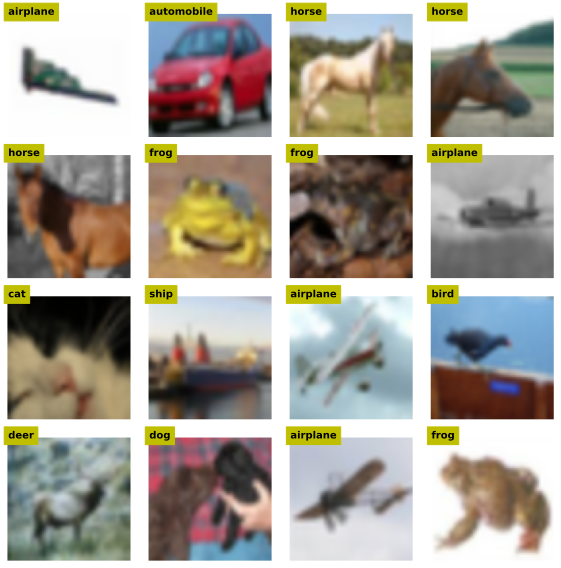

In [21]:
# inspect a few random images
X,y = next(iter(data_loader))

fig,axs = plt.subplots(4,4,figsize=(8,8))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = dataset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
# create classes for the generator and discriminator

class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias = False)
    self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
    self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
    self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
    self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias = False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), .2)
    # For positive inputs, the output is unchanged.
    # For negative inputs, the output is scaled by 0.2 (i.e., multiplied by 0.2).
    # For example:
    # If input = -3 → output = -0.6
    # If input = 2 → output = 2
    x = F.leaky_relu(self.conv2(x), .2)
    x = self.bn2(x)

    x = F.leaky_relu(self.conv3(x), .2)
    x = self.bn3(x)

    x = F.leaky_relu(self.conv4(x), .2)
    x = self.bn4(x)

    return torch.sigmoid(self.conv5(x)).view(-1, 1)

dnet = discriminatorNet()
y = dnet(torch.randn(10, 3, 64, 64))
y.shape

torch.Size([10, 1])

torch.Size([10, 3, 64, 64])


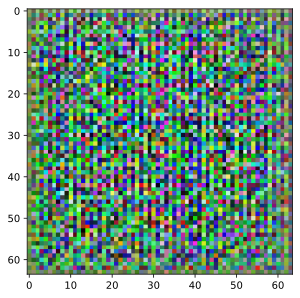

In [23]:
# create classes for the generator and discriminator

class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False)
    self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
    self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)
    self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(64)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = torch.tanh(self.conv5(x))
    return x

gnet = generatorNet()
y = gnet(torch.randn(10, 100, 1, 1))
print(y.shape)
pic = y[0, :, :, :].squeeze().detach().numpy().transpose((1, 2, 0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
plt.imshow(pic)

In [24]:
# loss function (same for both stages of training)
lossfun = nn.BCELoss()

# create instances of the model
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but diff variables b/c diff parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=0.0002, betas = (.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=0.0002, betas = (.5, .999))

In [ ]:
num_epochs = 50
losses  = []
disDecs = [] # disDecs = discriminator decisions

for epochi in range(num_epochs):

  for data, _ in data_loader:

    # send data to CPU
    data = data.to(device)

    # labels used for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)

    # Train the discriminator
    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)              # REAL images into discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_data = torch.randn(batchsize, 100, 1, 1).to(device)
    fake_images = gnet(fake_data) # output of generator
    pred_fake = dnet(fake_images) # FAKE images into discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train the generator
    # create fake images and compute loss
    fake_images = gnet(torch.randn(batchsize, 100, 1, 1).to(device))
    pred_fake   = dnet(fake_images)

    # compute and collect loss and accuracy
    g_loss = lossfun(pred_fake,real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # collect losses and discriminatir decisions
    losses.append([d_loss.item(), g_loss.item()])

    d1 = torch.mean((pred_real > .5).float()).detach().cpu().item()
    d2 = torch.mean((pred_fake > .5).float()).detach().cpu().item()
    disDecs.append([d1,d2])

  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)

# convert performance from list to numpy array
losses = np.array(losses)
disDecs = np.array(disDecs)

Finished epoch 34/50

In [ ]:
# create a 1d smoothing filter
def smooth(x, k = 15):
  return np.convolve(x, np.ones(k)/k, mode = 'same')

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic,cmap='gray')
  ax.axis('off')

plt.show()